<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/SelfANet_MRI_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Self-Attention Transformer

# MRI Brain Tumor Classification

# Requirmenets

In [ ]:
!pip install -U tensorflow-addons
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare the data

In [ ]:
drive.mount('/content/drive', force_remount=True)

num_classes = 4
input_shape = (160, 160, 3)
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    #batch_size=32,
    image_size=(160, 160),
    #validation_split=0.1,
    #subset="training",
    seed=1024
)

# test data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    #batch_size=32,
    image_size=(160, 160),
    #validation_split=0.1,
    #subset="validation",
    seed=1024
)


Mounted at /content/drive
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Configure the hyperparameters


In [ ]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 16
num_epochs = 30
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 2
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")


Patch size: 4 X 4 = 16 
Patches per image: 1600


# Implement the patch extraction and encoding layer


In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


# Implement the MLP block


In [ ]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x


# Implement the Transformer block


In [ ]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="self_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x


# Implement the Self-Attention Net model


In [ ]:
def get_model(attention_type="self_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    #x = data_augmentation(inputs)
    x = inputs
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train on MRI Dataset


In [ ]:
model = get_model(attention_type="self_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract (PatchExtract)   (None, 1600, 48)     0           ['input_1[0][0]']                
                                                                                                  
 patch_embedding (PatchEmbeddin  (None, 1600, 64)    105536      ['patch_extract[0][0]']          
 g)                                                                                               
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=num_epochs,
)

Epoch 1/30
179/179 [==============================] - 351s 2s/step - loss: 3.2628 - accuracy: 0.6017 - precision: 0.6243 - recall: 0.5600 - f1_score: 0.5873 - val_loss: 1.9449 - val_accuracy: 0.6415 - val_precision: 0.6592 - val_recall: 0.6079 - val_f1_score: 0.5521
Epoch 2/30
179/179 [==============================] - 34s 187ms/step - loss: 1.1497 - accuracy: 0.7482 - precision: 0.7693 - recall: 0.7251 - f1_score: 0.7430 - val_loss: 1.0158 - val_accuracy: 0.7818 - val_precision: 0.7911 - val_recall: 0.7742 - val_f1_score: 0.7606
Epoch 3/30
179/179 [==============================] - 34s 187ms/step - loss: 1.0367 - accuracy: 0.7815 - precision: 0.8012 - recall: 0.7612 - f1_score: 0.7758 - val_loss: 1.0111 - val_accuracy: 0.7620 - val_precision: 0.7861 - val_recall: 0.7346 - val_f1_score: 0.7309
Epoch 4/30
179/179 [==============================] - 34s 187ms/step - loss: 0.8595 - accuracy: 0.8157 - precision: 0.8354 - recall: 0.7924 - f1_score: 0.8080 - val_loss: 0.8805 - val_accuracy: 0

# Let's visualize the training progress of the model.


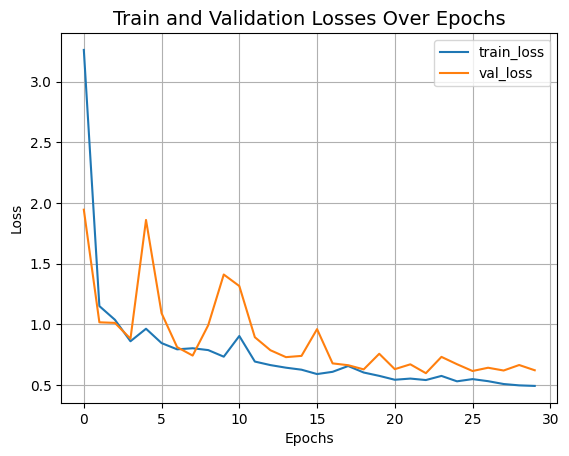

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()
